In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
reviews = pd.read_csv('data/tripadvisor_hotel_reviews.csv')

In [4]:
reviews.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [5]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [6]:
#distribution of ratings
ratings_distribution = reviews[['Rating']].value_counts()
print(ratings_distribution)

Rating
5         9054
4         6039
3         2184
2         1793
1         1421
dtype: int64


### Exploratory Data Analysis

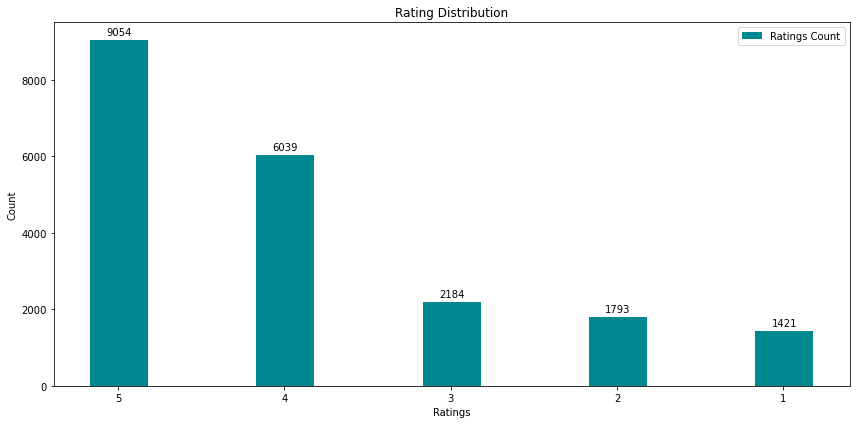

In [7]:
#plot of distribution of ratings
labels = ratings_distribution.index.get_level_values(0).values
distribution = ratings_distribution.values

x = np.arange(len(labels))
width = 0.35


fig, ax = plt.subplots(figsize=(12,6))
rect = ax.bar(x-width/2, distribution, width, label='Ratings Count', color='#008891')

# Add text for labels, title and custom x-axis tick labels
ax.set_ylabel('Count')
ax.set_xlabel('Ratings')
ax.set_title('Rating Distribution')
ax.set_xticks(x-0.18)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rect)
fig.savefig('plots/Ratings-Distribution.png', facecolor='w')
fig.tight_layout()
plt.show()

---------------
### Discretize the ratings variable into bins to adjust the imbalanced class distribution issue  

### Pre-processing Reviews
----------------

In [8]:
regex = 'https|<|>|=|;|:|\'|!|@|\/|#|$|%|\^|&|\*|\[|\]|\.|-|_|\d+|\+|\?|Û|¢|\(|\)|\||,'

In [9]:
def discretize(rating):
    """
    This function takes in a rating and based on the following scheme
    it puts it into 3 bins:
    1-2-3: Needs Improvement
    4: Good
    5: Amazing
    """
    if rating<=3:
        rating='Needs Improvement'
    elif rating==4:
        rating='Good'
    elif rating==5:
        rating='Amazing'
    return rating


def remove_patterns(review, regex='\d+'):
    """
    Given a review remove patterns which are unnecessary and do not add meaning to the review.
    """
    review = re.sub(regex, ' ', str(review))
    review = re.sub(' +', ' ', str(review))
    review = review.lstrip().rstrip()

    review = review.lower()

    return review


def clean_data(dataframe, cols=['Review', 'Rating']):
    """
    Take in the dataframe remove unneded patterns by applying remove_patterns on the review column and return the dataframe.
    """
    dataframe_2 = dataframe.copy()
    
    for col in cols:
        if col == 'Review':
            dataframe_2[col] = dataframe_2[col].apply(remove_patterns, regex=regex)
        if col == 'Rating':
            dataframe_2[col] = dataframe_2[col].apply(discretize)
    
    return dataframe_2

In [10]:
reviews = clean_data(reviews)

### Plot of class distribution after discretization

In [11]:
discrete_ratings_distribution = reviews[['Rating']].value_counts()

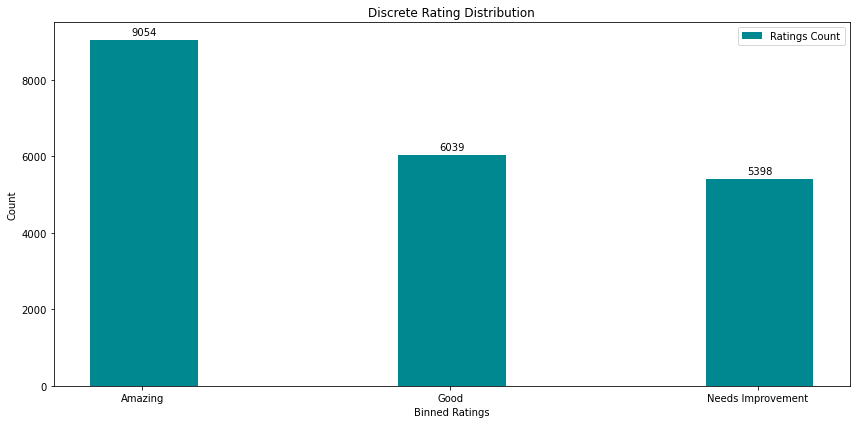

In [12]:
#plot of distribution of ratings
labels = discrete_ratings_distribution.index.get_level_values(0).values
distribution = discrete_ratings_distribution.values

x = np.arange(len(labels))
width = 0.35


fig, ax = plt.subplots(figsize=(12,6))
rect = ax.bar(x-width/2, distribution, width, label='Ratings Count', color='#008891')

# Add text for labels, title and custom x-axis tick labels
ax.set_ylabel('Count')
ax.set_xlabel('Binned Ratings')
ax.set_title('Discrete Rating Distribution')
ax.set_xticks(x-0.18)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rect)
fig.savefig('plots/Binned-Ratings-Distribution.png', facecolor='w')
fig.tight_layout()
plt.show()

In [13]:
reviews.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,Good
1,ok nothing special charge diamond member hilto...,Needs Improvement
2,nice rooms not experience hotel monaco seattle...,Needs Improvement
3,unique great stay wonderful time hotel monaco ...,Amazing
4,great stay great stay went seahawk game awesom...,Amazing


### Feature Engineering

In [14]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [15]:
def process_reviews(review):
    stopwords_english = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
#     stemmer = PorterStemmer()
#     snowball_stemmer = nltk.stem.SnowballStemmer('english')
    
    tokens = word_tokenize(review.lower())
    clean_review = []
    for word in tokens:
        if (word not in stopwords_english and 
           word not in string.punctuation):
            lemmatized_word = lemmatizer.lemmatize(word)            
#             stemmed_word = stemmer.stem(word)
            clean_review.append(lemmatized_word)
    return ' '.join(clean_review)

In [16]:
reviews['Review'] = reviews['Review'].apply(process_reviews)

In [17]:
reviews.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,Good
1,ok nothing special charge diamond member hilto...,Needs Improvement
2,nice room experience hotel monaco seattle good...,Needs Improvement
3,unique great stay wonderful time hotel monaco ...,Amazing
4,great stay great stay went seahawk game awesom...,Amazing


In [18]:
import joblib
import random
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.preprocessing import LabelEncoder

- uncomment when training a new vectorizer

In [33]:
vectorizer = TfidfVectorizer()
vectorizer_model = vectorizer.fit(reviews['Review'])

In [34]:
#save the vectorizer
joblib.dump(vectorizer_model, 'saved_models/vectorizer.pkl')

['saved_models/vectorizer.pkl']

In [35]:
vectorizer = joblib.load('saved_models/vectorizer.pkl')

In [36]:
vectorizer_transform = vectorizer.transform(reviews['Review'])

In [37]:
print(len(vectorizer.get_feature_names()))

44842


In [38]:
vectorized_reviews = pd.DataFrame(data = vectorizer_transform.toarray(), index=reviews.index, columns=vectorizer.get_feature_names())

In [75]:
random_features = random.sample(range(0, len(vectorizer.get_feature_names())), 10000)

In [76]:
encoder = LabelEncoder()
encoder.fit(reviews['Rating'])
reviews['Rating'] = encoder.transform(reviews['Rating'])

In [77]:
reviews.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,1
1,ok nothing special charge diamond member hilto...,2
2,nice room experience hotel monaco seattle good...,2
3,unique great stay wonderful time hotel monaco ...,0
4,great stay great stay went seahawk game awesom...,0


In [83]:
x = vectorized_reviews.iloc[:, random_features]
y = reviews['Rating']

### Feature Selection

In [84]:
# import sklearn
# nltk.__version__

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

In [85]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                   test_size=0.25,
                                                   random_state=123)

In [86]:
alphas = [0.2,0.3,0.4,0.5,1,2,3,4,5,6,7,8,9]

In [87]:
score = dict()
for alpha in alphas:
    svm = LinearSVC(C=alpha, random_state=0, penalty='l1', dual=False, multi_class='ovr')
    svm_fit = svm.fit(x_train, y_train)

    svm_predict = svm_fit.predict(x_test)
    
    score[alpha] = accuracy_score(y_test, svm_predict)

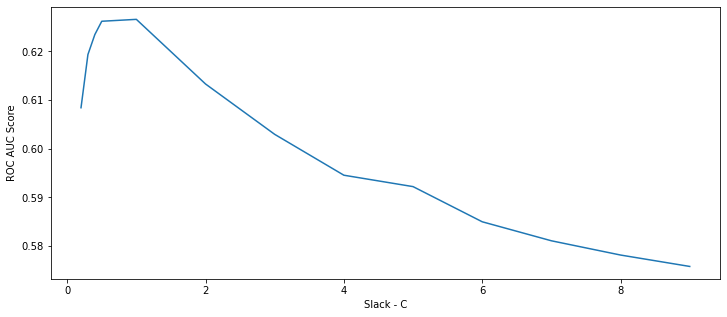

In [89]:
fig, ax = plt.subplots(figsize=(12,5))
ax = plt.plot(alphas, [score for score in score.values()])
plt.ylabel('ROC AUC Score')
plt.xlabel('Slack - C')
plt.show()
fig.savefig('plots/SVC_FeatureSelection.png')